In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Prepare Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedmustafa/real-life-violence-situations-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.58G/3.58G [03:17<00:00, 19.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mohamedmustafa/real-life-violence-situations-dataset/versions/1


In [ ]:
data_path=os.path.join(path,'Real Life Violence Dataset')

In [ ]:
def getDuration(video_path):
  cap=cv2.VideoCapture(video_path)
  if not cap.isOpened():
    print("Can open the video")
    exit()
    return
  frames=cap.get(cv2.CAP_PROP_FRAME_COUNT)
  fps=cap.get(cv2.CAP_PROP_FPS)

  duration= frames/fps
  cap.release()
  return int(duration)

In [ ]:
def convert2df(data_path):
  labels = os.listdir(data_path)
  data=[]
  for label in labels:
    video_paths = os.listdir(data_path+'/'+label)
    for video_path in video_paths:
      data.append(
          {
              'video_path':data_path+'/'+label+'/'+video_path,
              'label':label
          }
      )
  return pd.DataFrame(data)

In [ ]:
df=convert2df(data_path).sample(frac=1,random_state=42)
df['duration']=df.video_path.apply(getDuration)
df.head()

,video_path,label,duration
1860,/root/.cache/kagglehub/datasets/mohamedmustafa...,NonViolence,3
353,/root/.cache/kagglehub/datasets/mohamedmustafa...,Violence,3
1333,/root/.cache/kagglehub/datasets/mohamedmustafa...,NonViolence,5
905,/root/.cache/kagglehub/datasets/mohamedmustafa...,Violence,5
1289,/root/.cache/kagglehub/datasets/mohamedmustafa...,NonViolence,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1860 to 1126
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_path  2000 non-null   object
 1   label       2000 non-null   object
 2   duration    2000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 62.5+ KB


<Axes: >

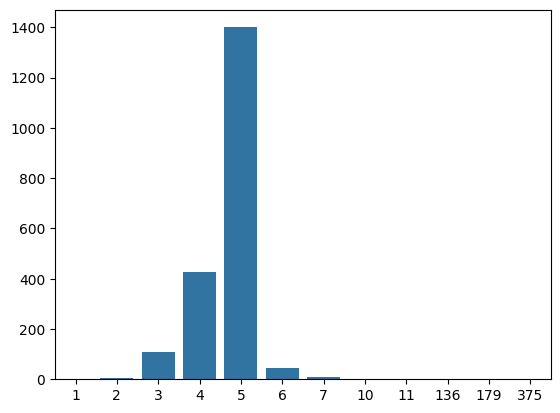

In [ ]:
durations,counts=np.unique(df.duration.values,return_counts=True)
sns.barplot(x=durations,y=counts)

<Axes: >

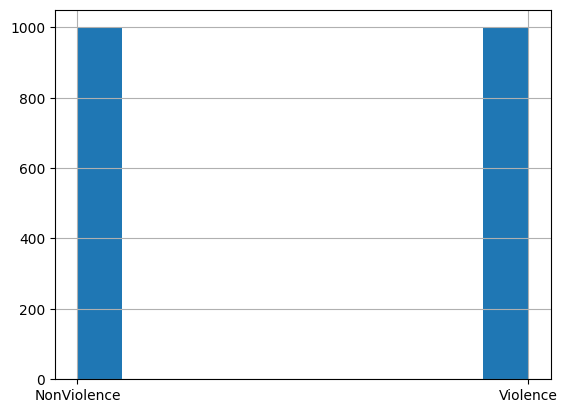

In [ ]:
df.label.hist()

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

train_set,test_set=train_test_split(df,test_size=0.25,random_state=42)

train_set,val_set=train_test_split(train_set,test_size=0.1,random_state=42)

# Define Dataset class and Dataloader

In [ ]:
def extract_frames(video_path,n_frames=10,transforms=None):
    cap=cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print('Can open this video!')
      return None
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval=total_frames//n_frames
    frames=[]
    for i in range(n_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i*frame_interval)
        ret, frame = cap.read()
        frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if not ret:
          break
        if(transforms):
          frame=transforms(image=frame)['image']
        frames.append(frame)
    cap.release()
    cv2.destroyAllWindows()
    return torch.stack(frames)

In [ ]:
class ViolenceDataset(Dataset):
  def __init__(self,df,n_frames,transfroms=None):
    super().__init__()
    self.df=df
    self.transforms=transfroms
    self.n_frames=n_frames
  def __len__(self):
    return len(self.df)
  def __getitem__(self, index):
      video_path=self.df.iloc[index,0]
      frames=extract_frames(video_path,self.n_frames,self.transforms)
      if frames is None:
        return
      elif len(frames)!=self.n_frames: return
      label= 0 if self.df.iloc[index,1]=='NonViolence' else 1
      return frames,label

In [ ]:
import albumentations as A
from albumentations.pytorch import transforms as transforms

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
train_transforms=A.Compose([
    A.Resize(256,256),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.33),
    transforms.ToTensorV2()
])
test_transforms=A.Compose([
    A.Resize(256,256),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    transforms.ToTensorV2(),
])

In [ ]:
batch_size=32
n_frames=10

In [ ]:
train_loader=DataLoader(
    dataset=ViolenceDataset(train_set,n_frames,train_transforms),batch_size=batch_size,shuffle=True
)
val_loader=DataLoader(
    dataset=ViolenceDataset(val_set,n_frames,test_transforms),batch_size=batch_size,shuffle=True
)
test_loader=DataLoader(
    dataset=ViolenceDataset(test_set,n_frames,test_transforms),batch_size=batch_size,shuffle=False
)

# Define Model

In [ ]:
class Model(nn.Module):
  def __init__(self,num_class):
    super().__init__()
    '''
    input: (N,n_frames,3,256,256)
    output:
    '''
    self.features=nn.Sequential(
        torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1').features,#(N*n_frames,576,9,8)
        nn.AdaptiveAvgPool2d((1,1)), #(N*n_frames,576,1,1)
        nn.Flatten(), #(N*n_frames,576)
        )
    self.lstm=nn.LSTM(input_size=576,hidden_size=256,num_layers=1,batch_first=True,bidirectional=True) #(N,n_frames,256*2)
    self.fc=nn.Sequential(
        nn.Linear(in_features=512,out_features=128),
        nn.GELU(),
        nn.Linear(in_features=128,out_features=num_class)
    )
  def forward(self,x):
    # print(x.shape)
    batch_size=x.shape[0]
    n_frames=x.shape[1]
    x=x.view(-1,3,256,256)#(N*n_frames,3,256,256)
    # print(x.shape)
    x=self.features(x)#(N*n_frames,576)
    # print(x.shape)
    x=x.view(batch_size,n_frames,-1)#(N,n_frames,576)
    # print(x.shape)
    output,h_n=self.lstm(x)#(N,n_frames,512)

    return self.fc(output[:,-1,:])

In [ ]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model1=Model(num_class=2)
model1.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 146MB/s]


Model(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
! pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model1,(8,10,3,256,256))

Layer (type:depth-idx)                                  Output Shape              Param #
Model                                                   [8, 2]                    --
├─Sequential: 1-1                                       [80, 576]                 --
│    └─Sequential: 2-1                                  [80, 576, 8, 8]           --
│    │    └─Conv2dNormActivation: 3-1                   [80, 16, 128, 128]        464
│    │    └─InvertedResidual: 3-2                       [80, 16, 64, 64]          744
│    │    └─InvertedResidual: 3-3                       [80, 24, 32, 32]          3,864
│    │    └─InvertedResidual: 3-4                       [80, 24, 32, 32]          5,416
│    │    └─InvertedResidual: 3-5                       [80, 40, 16, 16]          13,736
│    │    └─InvertedResidual: 3-6                       [80, 40, 16, 16]          57,264
│    │    └─InvertedResidual: 3-7                       [80, 40, 16, 16]          57,264
│    │    └─InvertedResidual: 3-8       

# Define Loss and optimizer

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self,gamma=2,alpha=1,reduction='mean'):
      super().__init__()
      self.gamma=gamma
      self.alpha=alpha
      self.reduction=reduction
    def forward(self,pred,label):
      ce=F.cross_entropy(pred,label)
      pt=torch.exp(-ce)
      fcloss=self.alpha*(1-pt)**(self.gamma)*ce
      if(self.reduction=='mean'):
        return torch.mean(fcloss)
      elif(self.reduction=='sum'):
        return torch.sum(fcloss)

# Training

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
def eval(device,model,val_loader,criterion):
  model.to(device)
  model.eval()
  val_loss=0
  val_acc=0
  val_f1=0
  with torch.no_grad():
    for vids,labels in val_loader:
      vids,labels=vids.to(device),labels.to(device)
      preds=model(vids)
      loss=criterion(preds,labels)
      val_loss+=loss.item()
      label_preds=torch.argmax(preds,dim=1).cpu().numpy()
      labels=labels.cpu().numpy()
      val_acc+=accuracy_score(labels,label_preds)
      val_f1+=f1_score(labels,label_preds)
  val_loss/=len(val_loader)
  val_acc/=len(val_loader)
  val_f1/=len(val_loader)
  return val_loss,val_acc,val_f1

In [ ]:
from torch.optim import Adam
criterion=FocalLoss()
optimizer=Adam(model1.parameters(),lr=1e-3)

In [ ]:
from torch.optim import Adam

def train_one_epoch(device,model,train_loader,criterion,optimizer,val_loader=None,val=True):
    model.to(device)
    model.train()
    training_loss=0
    training_acc=0
    training_f1=0
    for vids,labels in train_loader:
        optimizer.zero_grad()
        vids,labels=vids.to(device),labels.to(device)
        preds=model(vids)
        loss=criterion(preds,labels)
        training_loss+=loss.item()
        label_preds=torch.argmax(preds,dim=1).cpu().numpy()
        labels=labels.cpu().numpy()
        training_acc+=accuracy_score(labels,label_preds)
        training_f1+=f1_score(labels,label_preds)
        loss.backward()
        optimizer.step()
    training_loss/=len(train_loader)
    training_acc/=len(train_loader)
    training_f1/=len(train_loader)
    if((val) and (val_loader)):
      val_loss,val_acc,val_f1=eval(device,model,val_loader,criterion)
      return training_loss,training_acc,training_f1,val_loss,val_acc,val_f1
    return training_loss,training_acc,training_f1

In [ ]:
epochs=5
save_dir='/content/drive/MyDrive/best_model.pt'
best_f1=-1e3
hist={
    'train_loss':[],
    'train_acc':[],
    'train_f1':[],
    'val_loss':[],
    'val_acc':[],
    'val_f1':[]
}

In [ ]:
for i in tqdm(range(epochs)):
    training_loss,training_acc,training_f1,val_loss,val_acc,val_f1=train_one_epoch(device,model1,train_loader,criterion,optimizer,val_loader,val=True)
    print(f'Epoch [{i}/{epochs}]:training_loss {training_loss}, training_acc {training_acc}, training_f1 {training_f1}, val_loss {val_loss}, val_acc {val_acc}, val_f1 {val_f1}')
    hist['train_loss'].append(training_loss)
    hist['train_acc'].append(training_acc)
    hist['train_f1'].append(training_f1)
    hist['val_loss'].append(val_loss)
    hist['val_acc'].append(val_acc)
    hist['val_f1'].append(val_f1)
    if (val_f1>best_f1):
      best_f1=val_f1
      print('=> Save')
      torch.save(model1.state_dict(), save_dir)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [0/5]:training_loss 0.06373565982442436, training_acc 0.8243701550387597, training_f1 0.8291591882011203, val_loss 0.03322411589324474, val_acc 0.8573863636363637, val_f1 0.8566442388561816
=> Save


 40%|████      | 2/5 [09:54<14:50, 297.00s/it]

Epoch [1/5]:training_loss 0.011320763501761005, training_acc 0.9280523255813954, training_f1 0.9298715269346456, val_loss 0.025196255650371313, val_acc 0.8914772727272726, val_f1 0.895181210945917
=> Save


 60%|██████    | 3/5 [14:49<09:52, 296.17s/it]

Epoch [2/5]:training_loss 0.001994811543449201, training_acc 0.967296511627907, training_f1 0.9678805850054112, val_loss 0.0037226252490654586, val_acc 0.953409090909091, val_f1 0.9528783843372433
=> Save


 80%|████████  | 4/5 [19:44<04:55, 295.66s/it]

Epoch [3/5]:training_loss 0.004989971106455372, training_acc 0.9624515503875969, training_f1 0.9613090506398482, val_loss 0.0041421182759222575, val_acc 0.947159090909091, val_f1 0.9416215363583784


100%|██████████| 5/5 [24:39<00:00, 295.91s/it]

Epoch [4/5]:training_loss 0.04197587671872096, training_acc 0.876453488372093, training_f1 0.8767351055082843, val_loss 0.08010662049055099, val_acc 0.8568181818181818, val_f1 0.8381544215485309


# Evaluate on test_set

In [36]:
best_model=Model(num_class=2)
best_model.load_state_dict(torch.load(save_dir, weights_only=True))

<All keys matched successfully>

In [37]:
val_loss,val_acc,val_f1=eval(device,best_model,test_loader,criterion)
print(f'val_loss {val_loss}, val_acc {val_acc}, val_f1 {val_f1}')

val_loss 0.017668567429865334, val_acc 0.92265625, val_f1 0.921496685323247


# Train Last timne with all dataset

In [38]:
criterion=FocalLoss()
optimizer=Adam(best_model.parameters(),lr=1e-3)
all_data_loader=DataLoader(
    dataset=ViolenceDataset(df,n_frames,train_transforms),batch_size=94,shuffle=True
)
best_training_f1=-1e3
last_hist={
    'train_loss':[],
    'train_acc':[],
    'train_f1':[],
}
max_epochs=5
for i in tqdm(range(max_epochs)):
    training_loss,training_acc,training_f1=train_one_epoch(device,best_model,all_data_loader,criterion,optimizer,val_loader=None,val=False)
    print(f'Epoch [{i+1}/{max_epochs}]:training_loss {training_loss}, training_acc {training_acc}, training_f1 {training_f1}')
    last_hist['train_loss'].append(training_loss)
    last_hist['train_acc'].append(training_acc)
    last_hist['train_f1'].append(training_f1)
    if (training_f1>best_training_f1):
      best_training_f1=training_f1
      print('=> Save')
      torch.save(best_model.state_dict(), save_dir)

 20%|██        | 1/5 [06:31<26:06, 391.61s/it]

Epoch [1/5]:training_loss 0.002594629612510537, training_acc 0.9590834697217677, training_f1 0.9586253730520329
=> Save


 40%|████      | 2/5 [13:01<19:31, 390.42s/it]

Epoch [2/5]:training_loss 0.0012840866832200184, training_acc 0.9619848236869515, training_f1 0.9618707747193064
=> Save


 60%|██████    | 3/5 [19:31<13:00, 390.36s/it]

Epoch [3/5]:training_loss 0.001288392193745577, training_acc 0.9739622080047613, training_f1 0.9713780906528275
=> Save


 80%|████████  | 4/5 [26:01<06:30, 390.20s/it]

Epoch [4/5]:training_loss 0.00665934874930165, training_acc 0.946808510638298, training_f1 0.9463779891933211


100%|██████████| 5/5 [32:31<00:00, 390.25s/it]

Epoch [5/5]:training_loss 0.0007222313521941197, training_acc 0.9684570748400538, training_f1 0.9689922022184114


# Save in ONNX format

In [39]:
last_model=Model(num_class=2)
last_model.load_state_dict(torch.load(save_dir, weights_only=True))

<All keys matched successfully>

In [40]:
!pip install --upgrade onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.8/720.8 kB 10.8 MB/s eta 0:00:00


In [41]:
last_model.eval()
dummy_input = torch.randn(1,10, 3,256,256)

In [42]:
torch.onnx.export(
    last_model,
    dummy_input,
    "/content/drive/MyDrive/model_quantized.onnx",
    opset_version=11,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {1: "num_frames"},
    }
)

/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
